In [2]:
"""
arxiv_time_series_analysis.py

This script fetches Time Series-related papers from arXiv, filters by relevant categories,
performs basic keyword analysis, generates word clouds, and visualizes counts of 
Foundation and Advanced Methods in the literature.

Dependencies:
- pandas
- arxiv
- matplotlib
- wordcloud
"""

# -----------------------------------------
# Install dependencies if needed
# -----------------------------------------
# Uncomment if running in a fresh environment (e.g., Colab)
# !pip install arxiv pandas matplotlib wordcloud

# -----------------------------------------
# Import libraries
# -----------------------------------------
import pandas as pd
import arxiv
import time
import warnings
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ignore deprecation warnings
warnings.filterwarnings('ignore')

# -----------------------------------------
# Step 1: Fetch articles from arXiv
# -----------------------------------------
def search_arxiv(query, max_results=1000, retry_delay=5):
    """
    Fetches papers from arXiv based on query.
    
    Parameters:
        query (str): Search query for arXiv
        max_results (int): Maximum number of articles to fetch
        retry_delay (int): Seconds to wait if an error occurs
    
    Returns:
        pandas.DataFrame: DataFrame with article metadata
    """
    data = {}
    i = 0

    search = arxiv.Search(query=query, max_results=max_results)

    for result in search.results():
        try:
            data[i] = {
                'title': result.title,
                'date_published': result.published,
                'authors': [a.name for a in result.authors],
                'summary': result.summary,
                'url': result.pdf_url,
                'category': result.primary_category
            }
            i += 1

        except Exception as e:
            print(f'Arxiv fetch error: {e}, retrying in {retry_delay}s')
            time.sleep(retry_delay)
            continue

    # Convert to DataFrame and clean
    df = pd.DataFrame(data).T
    df = df[['date_published', 'title', 'authors', 'summary', 'url', 'category']]
    df['date_published'] = pd.to_datetime(df['date_published'])
    df.sort_values('date_published', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# -----------------------------------------
# Step 2: Run query
# -----------------------------------------
query = 'Time Series'
max_results = 10  # Large numbers may take time; consider batching for >1000

df = search_arxiv(query, max_results)

# Save to CSV for backup
df.to_csv('arxiv_time_series_data.csv', index=False)


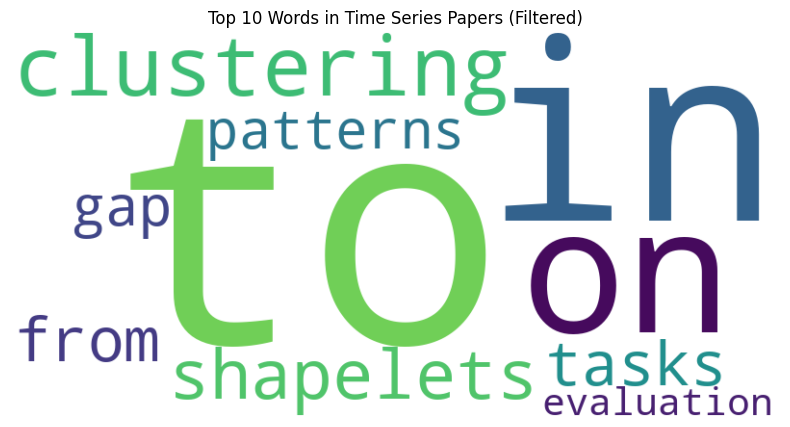

In [3]:

# -----------------------------------------
# Step 3: Filter by relevant categories
# -----------------------------------------
included_categories = ['cs.LG', 'stat.ME', 'math.ST', 'stat.ML']
df_filtered = df[df['category'].isin(included_categories)]
df_filtered.to_csv('time_series_filtered.csv', index=False)

# -----------------------------------------
# Step 4: Generate a word cloud from summaries
# -----------------------------------------
# Define stop words
stop_words = set([
    'as','is','a','are','it','paper','based','proposed','an','approach',
    'using','time-series','learning','performance','results','these',
    'show','have','has','datasets','propose','classification','two','also',
    'used','different','analysis','problem','new','framework','novel','been',
    'demonstrate','that','this','be','which','proposed','time','data','method',
    'methods','our','we','series','forecasting','model','models','the','model',
    'and','or','but','if','of','at','by','for','with','about','against',
    'between','into','through','during','many','however','existing','its',
    'prediction','application'
])

# Count word frequencies
word_freq = Counter()
for summary in df_filtered['summary']:
    words = summary.split()
    for w in words:
        w = w.lower().rstrip('.!,')
        if w not in stop_words:
            word_freq[w] += 1

# Generate word cloud for top 10 words
most_common_words = dict(word_freq.most_common(10))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(most_common_words)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 10 Words in Time Series Papers (Filtered)')
plt.show()


In [4]:

# -----------------------------------------
# Step 5: Keyword analysis (Foundation vs Advanced Methods)
# -----------------------------------------
Foundation_keywords = ['arima', 'samira', 'lstm', 'conformal prediction', 'multivariate time series', 'vector autoregression']
Advanced_Methods_keywords = ['transformer', 'gan', 'edain', 'mlp', 'deep learning', 'neural networks', 'supervised learning']

def count_keywords(text):
    """
    Counts the occurrence of Foundation and Advanced Methods keywords.
    Returns two integers.
    """
    words = re.findall(r'\b\w+\b', text.lower())
    foundation_count = sum(word in Foundation_keywords for word in words)
    advanced_count = sum(word in Advanced_Methods_keywords for word in words)
    return foundation_count, advanced_count

df_filtered[['foundation_count','advanced_methods_count']] = df_filtered['summary'].apply(lambda x: pd.Series(count_keywords(x)))


IndexError: index 0 is out of bounds for axis 0 with size 0

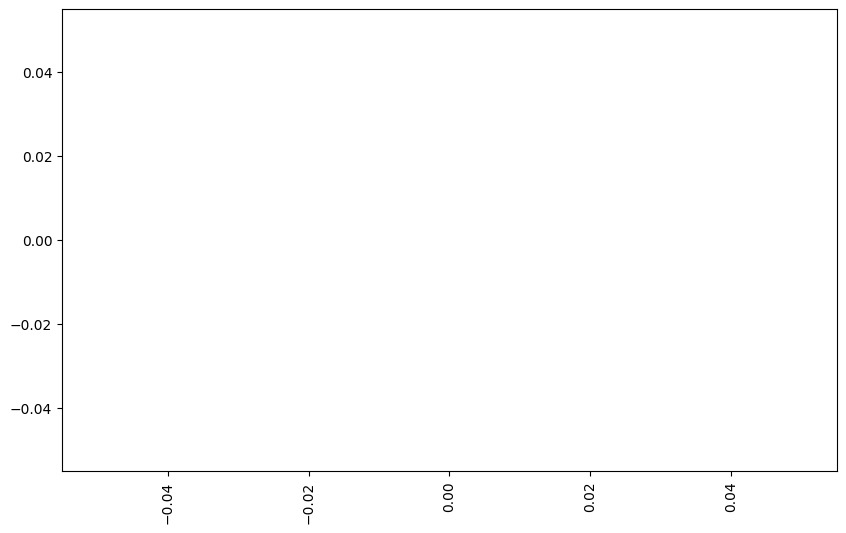

In [6]:

# -----------------------------------------
# Step 6: Visualize keyword counts
# -----------------------------------------
# Foundation counts (excluding zeros)
foundation_counts = df_filtered['foundation_count'].value_counts().sort_index()
foundation_counts = foundation_counts[foundation_counts.index != 0]
plt.figure(figsize=(10,6))
foundation_counts.plot(kind='bar', color='skyblue')
plt.title('Foundation Methods Count Frequency (Excluding Zero Count)')
plt.xlabel('Foundation Count')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:

# Advanced Methods counts (excluding zeros)
advanced_counts = df_filtered['advanced_methods_count'].value_counts().sort_index()
advanced_counts = advanced_counts[advanced_counts.index != 0]
plt.figure(figsize=(10,6))
advanced_counts.plot(kind='bar', color='coral')
plt.title('Advanced Methods Count Frequency (Excluding Zero Count)')
plt.xlabel('Advanced Methods Count')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
